# This notebook trains multimodal model for attention interruption prediction

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.patches as patches
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import re

np.random.seed(0)
tf.random.set_seed(0)

# load dataset


In [ ]:
data = pd.read_csv('../dataset/dataset0629.csv')

In [6]:
X_train = pd.read_csv('../dataset/dataset_train_x0629.csv')
y_train = pd.read_csv('../dataset/dataset_train_y0629.csv')
X_test = pd.read_csv('../dataset/dataset_test_x0629.csv')
y_test = pd.read_csv('../dataset/dataset_test_y0629.csv')

In [7]:
# Properly scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = np.reshape(y_train, (-1,))
y_test = np.reshape(y_test, (-1,))

In [8]:
print('training dataset shape:' , X_train.shape)
print('testing dataset shape: ', X_test.shape}

((596, 297), (150, 297))

## distribution of attention interruption score

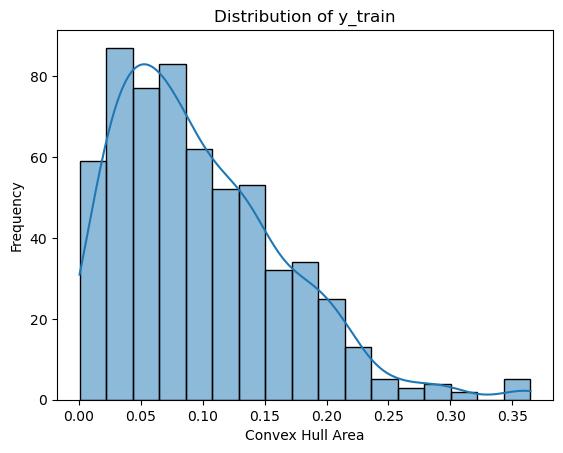

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(y_train, kde=True)
plt.title("Distribution of y_train")
plt.xlabel("Convex Hull Area")
plt.ylabel("Frequency")
plt.show()

# benchmarks


In [51]:
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [52]:
models = {
    'Support Vector Machine': SVR(C=2, epsilon=0.1, kernel='rbf'),
    'Neural Network': MLPRegressor(max_iter=1000),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, random_state=42),
    'Linear Regression': LinearRegression(),
    'Lasso (L1 Regularization)': Lasso(alpha=0.01, random_state=42),
    'Ridge (L2 Regularization)': Ridge(alpha=1.0, random_state=42)
}

In [211]:
# Evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train.ravel())
    y_pred = model.predict(X_test_scaled)
    mse = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'mse': mse.round(4), 'r2': r2.round(6), 'y_pred': y_pred.round(6)}
    print(f"{name} - Mean Squared Error: {mse.round(4)}, R-squared: {r2.round(4)}")

Support Vector Machine - Mean Squared Error: 0.0679, R-squared: -0.0259
Neural Network - Mean Squared Error: 0.0375, R-squared: 0.4788
Random Forest - Mean Squared Error: 0.0366, R-squared: 0.4866
Gradient Boosting - Mean Squared Error: 0.0367, R-squared: 0.4938
Linear Regression - Mean Squared Error: 0.0375, R-squared: 0.4781
Lasso (L1 Regularization) - Mean Squared Error: 0.0576, R-squared: -0.0024
Ridge (L2 Regularization) - Mean Squared Error: 0.0365, R-squared: 0.4919


# Multimodal model


In [163]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.losses import MeanAbsoluteError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from tensorflow import keras

In [40]:
visual_names = ['color_brightness_mean', 'color_brightness_std', 'color_hue_mean', 'color_hue_std', 'color_saturation_mean', 'color_saturation_std', 'color_brightness_contrast_mean', 'color_brightness_contrast_std', 'color_color_diversity_mean', 'color_color_diversity_std', 'color_clarity_mean', 'color_clarity_std', 'color_black_mean', 'color_black_std', 'color_blue_mean', 'color_blue_std', 'color_brown_mean', 'color_brown_std', 'color_gray_mean', 'color_gray_std', 'color_green_mean', 'color_green_std', 'color_orange_mean', 'color_orange_std', 'color_pink_mean', 'color_pink_std', 'color_purple_mean', 'color_purple_std', 'color_red_mean', 'color_red_std', 'color_white_mean', 'color_white_std', 'color_yellow_mean', 'color_yellow_std', 'texture_c1_contrast_mean', 'texture_c1_contrast_std', 'texture_c1_correlation_mean', 'texture_c1_correlation_std', 'texture_c1_energy_mean', 'texture_c1_energy_std', 'texture_c1_homogeneity_mean', 'texture_c1_homogeneity_std', 'texture_c1_dissimilarity_mean', 'texture_c1_dissimilarity_std', 'texture_c2_contrast_mean', 'texture_c2_contrast_std', 'texture_c2_correlation_mean', 'texture_c2_correlation_std', 'texture_c2_energy_mean', 'texture_c2_energy_std', 'texture_c2_homogeneity_mean', 'texture_c2_homogeneity_std', 'texture_c2_dissimilarity_mean', 'texture_c2_dissimilarity_std', 'texture_c3_contrast_mean', 'texture_c3_contrast_std', 'texture_c3_correlation_mean', 'texture_c3_correlation_std', 'texture_c3_energy_mean', 'texture_c3_energy_std', 'texture_c3_homogeneity_mean', 'texture_c3_homogeneity_std', 'texture_c3_dissimilarity_mean', 'texture_c3_dissimilarity_std', 'inner_brightness_mean', 'inner_brightness_std', 'inner_sharpness_mean', 'inner_sharpness_std', 'objects_count_yolo_mean', 'objects_count_yolo_std', 'face_count_yolo_mean', 'face_count_yolo_std', 'region_size_avg_mean', 'region_size_avg_std', 'region_count_mean', 'region_count_std', 'rule_of_thirds_mean', 'rule_of_thirds_std']

In [41]:
text_names = ['wc', 'analytic', 'clout', 'authentic', 'tone', 'wps', 'bigwords', 'dic', 'linguistic', 'function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'det', 'article', 'number', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'quantity', 'drives', 'affiliation', 'achieve', 'power', 'cognition', 'allnone', 'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certitude', 'differ', 'memory', 'affect', 'tone_pos', 'tone_neg', 'emotion', 'emo_pos', 'emo_neg', 'emo_anx', 'emo_anger', 'emo_sad', 'swear', 'social', 'socbehav', 'prosocial', 'polite', 'conflict', 'moral', 'comm', 'socrefs', 'family', 'friend', 'female', 'male', 'culture', 'politic', 'ethnicity', 'tech', 'lifestyle', 'leisure', 'home', 'work', 'money', 'relig', 'physical', 'health', 'illness', 'wellness', 'mental', 'substances', 'sexual', 'food', 'death', 'need', 'want', 'acquire', 'lack', 'fulfill', 'fatigue', 'reward', 'risk', 'curiosity', 'allure', 'perception', 'attention', 'motion', 'space', 'visual', 'auditory', 'feeling', 'time', 'focuspast', 'focuspresent', 'focusfuture', 'conversation', 'netspeak', 'assent', 'nonflu', 'filler', 'allpunc', 'period', 'comma', 'qmark', 'exclam', 'apostro', 'otherp', 'emoji', 'absolutist', 'agitation', 'dejection', 'accomplishment', 'behavioral_activation', 'breadth', 'decisions', 'effort_enjoyment', 'longterm', 'satisfaction', 'structure', 'competence', 'excitement', 'not_relevant', 'ruggedness', 'sincerity', 'sophistication', 'highcontroversial', 'lowcontroversial', 'mediumcontroversial', 'benefit', 'cost', 'creativity_innovation', 'alterations', 'cogs_precogs', 'enchantment_emotions', 'fabulations', 'infinity_eternity', 'renewal', 'spiritual_imagery', 'total', 'vision', 'agency', 'agentrelatedemotions', 'experience', 'mindoverall', 'patientrelatedemotions', 'security']

In [42]:
audio_names = ['rms_mean', 'rms_std', 'rms_max', 'zcr_mean', 'zcr_std', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_bandwidth_mean', 'spectral_bandwidth_std', 'pitch_mean', 'pitch_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std', 'mfcc_5_mean', 'mfcc_5_std', 'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean', 'mfcc_7_std', 'mfcc_8_mean', 'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std', 'mfcc_10_mean', 'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std', 'mfcc_12_mean', 'mfcc_12_std', 'mfcc_13_mean', 'mfcc_13_std', 'chroma_1_mean', 'chroma_1_std', 'chroma_2_mean', 'chroma_2_std', 'chroma_3_mean', 'chroma_3_std', 'chroma_4_mean', 'chroma_4_std', 'chroma_5_mean', 'chroma_5_std', 'chroma_6_mean', 'chroma_6_std', 'chroma_7_mean', 'chroma_7_std', 'chroma_8_mean', 'chroma_8_std', 'chroma_9_mean', 'chroma_9_std', 'chroma_10_mean', 'chroma_10_std', 'chroma_11_mean', 'chroma_11_std', 'chroma_12_mean', 'chroma_12_std', 'mel_spectrogram_mean', 'mel_spectrogram_std']

In [43]:
scaler = StandardScaler()

# Separate feature sets
visual_features = [col for col in data.columns if col in visual_names]
audio_features = [col for col in data.columns if col in audio_names]
linguistic_features = [col for col in data.columns if col in text_names]

X_visual = scaler.fit_transform(data[visual_features])
X_audio = scaler.fit_transform(data[audio_features])
X_linguistic = scaler.fit_transform(data[linguistic_features])

In [44]:
print('count of visual features: ', X_visual.shape[1])
print('count of audio features: ', X_audio.shape[1])
print('count of linguistic features: ', X_linguistic.shape[1])

78

In [ ]:
# concatenate all features
X_train_combined = [X_train_scaled[:, :X_visual.shape[1]], 
                    X_train_scaled[:, X_visual.shape[1]:X_visual.shape[1] + X_audio.shape[1]], 
                    X_train_scaled[:, X_visual.shape[1] + X_audio.shape[1]:]]
X_test_combined = [X_test_scaled[:, :X_visual.shape[1]], 
                   X_test_scaled[:, X_visual.shape[1]:X_visual.shape[1] + X_audio.shape[1]], 
                   X_test_scaled[:, X_visual.shape[1] + X_audio.shape[1]:]]

In [45]:
# custom call back to print the training loss
class CustomCallback(Callback):
    def __init__(self, display=10):
        self.display = display

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.display == 0:
            try:
                print(f"Epoch {epoch}, loss: {logs['loss']:.4f}, val_loss: {logs['val_loss']:.4f}")
            except:
                print(f"Epoch {epoch}, loss: {logs['loss']:.4f}")

custom_callback = CustomCallback(display=10)

## base model


In [232]:
input_visual = Input(shape=(X_visual.shape[1],))
input_audio = Input(shape=(X_audio.shape[1],))
input_linguistic = Input(shape=(X_linguistic.shape[1],))

# Define dense layers for each input
dense_visual = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(input_visual)
dense_visual = BatchNormalization()(dense_visual)
dense_audio = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(input_audio)
dense_audio = BatchNormalization()(dense_audio)
dense_linguistic = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(input_linguistic)
dense_linguistic = BatchNormalization()(dense_linguistic)

# Concatenate layers
concat = Concatenate()([dense_visual, dense_audio, dense_linguistic])
concat = Dropout(0.1)(concat)  # Add dropout after concatenation

# Add a dense layer after concatenation
dense_combined = Dense(32, activation='relu', kernel_regularizer='l2')(concat)
dense_combined = Dropout(0.1)(dense_combined)  # Add dropout to the dense layer
output = Dense(1)(dense_combined)

# Create model
model = Model(inputs=[input_visual, input_audio, input_linguistic], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError())

In [241]:
#loaded_model = keras.models.load_model('../weights/base.keras')
#Predict on the test data
y_pred = loaded_model.predict(X_test_combined)
mse = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE) on test data: {mse}")
print(f"R² (coefficient of determination) on test data: {r2}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Mean Squared Error (MSE) on test data: 0.03591767634445268
R² (coefficient of determination) on test data: 0.5168167160989887


## change output layer to Sigmoid


In [248]:
input_visual = Input(shape=(X_visual.shape[1],))
input_audio = Input(shape=(X_audio.shape[1],))
input_linguistic = Input(shape=(X_linguistic.shape[1],))

# Define dense layers for each input
dense_visual = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(input_visual)
dense_visual = BatchNormalization()(dense_visual)
dense_audio = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(input_audio)
dense_audio = BatchNormalization()(dense_audio)
dense_linguistic = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(input_linguistic)
dense_linguistic = BatchNormalization()(dense_linguistic)

# Concatenate layers
concat = Concatenate()([dense_visual, dense_audio, dense_linguistic])
concat = Dropout(0.1)(concat)  # Add dropout after concatenation

# Add a dense layer after concatenation
dense_combined = Dense(32, activation='relu', kernel_regularizer='l2')(concat)
dense_combined = Dropout(0.1)(dense_combined)  # Add dropout to the dense layer
output = Dense(1, activation='sigmoid')(dense_combined)


# Create model
model = Model(inputs=[input_visual, input_audio, input_linguistic], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError())

In [252]:
#loaded_model = keras.models.load_model('../weights/sigmoid.keras')
#Predict on the test data
y_pred = loaded_model.predict(X_test_combined)
mse = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE) on test data: {mse}")
print(f"R² (coefficient of determination) on test data: {r2}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Mean Squared Error (MSE) on test data: 0.03454542636199868
R² (coefficient of determination) on test data: 0.5216307303105302


## Elu + Sigmoid


In [268]:
input_visual = Input(shape=(X_visual.shape[1],))
input_audio = Input(shape=(X_audio.shape[1],))
input_linguistic = Input(shape=(X_linguistic.shape[1],))

# Define dense layers for each input
dense_visual = Dense(16, activation='elu', kernel_regularizer=l2(0.01))(input_visual)
dense_visual = BatchNormalization()(dense_visual)
dense_audio = Dense(16, activation='elu', kernel_regularizer=l2(0.01))(input_audio)
dense_audio = BatchNormalization()(dense_audio)
dense_linguistic = Dense(16, activation='elu', kernel_regularizer=l2(0.01))(input_linguistic)
dense_linguistic = BatchNormalization()(dense_linguistic)

# Concatenate layers
concat = Concatenate()([dense_visual, dense_audio, dense_linguistic])
concat = Dropout(0.1)(concat)  # Add dropout after concatenation

# Add a dense layer after concatenation
dense_combined = Dense(32, activation='elu', kernel_regularizer='l2')(concat)
dense_combined = Dropout(0.1)(dense_combined)  # Add dropout to the dense layer
output = Dense(1, activation='sigmoid')(dense_combined)

# Create model
model = Model(inputs=[input_visual, input_audio, input_linguistic], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError())

In [ ]:
Epoch 0, loss: 1.3499, val_loss: 1.1842
Epoch 10, loss: 0.1480, val_loss: 0.1410
Epoch 20, loss: 0.0532, val_loss: 0.0602
Epoch 30, loss: 0.0414, val_loss: 0.0426
Epoch 40, loss: 0.0402, val_loss: 0.0498
Epoch 50, loss: 0.0393, val_loss: 0.0420
Epoch 60, loss: 0.0373, val_loss: 0.0436
Epoch 70, loss: 0.0383, val_loss: 0.0421
Epoch 80, loss: 0.0392, val_loss: 0.0412

In [270]:
# Predict on the test data
y_pred = model.predict(X_test_combined)
mse = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE) on test data: {mse}")
print(f"R² (coefficient of determination) on test data: {r2}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Mean Squared Error (MSE) on test data: 0.03503379090268315
R² (coefficient of determination) on test data: 0.5417855692907468


In [274]:
#loaded_model = keras.models.load_model('../weights/elu_sigmoid.keras')

#Predict on the test data
y_pred = loaded_model.predict(X_test_combined)
mse = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE) on test data: {mse}")
print(f"R² (coefficient of determination) on test data: {r2}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Mean Squared Error (MSE) on test data: 0.03503379090268315
R² (coefficient of determination) on test data: 0.5417855692907468
